# **Importing libraries and loading the data**

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings("ignore")

The dataset that we will work with, is the famous Titanic dataset from [kaggle](https://www.kaggle.com/c/titanic).

In [27]:
df = pd.read_csv('/content/titanic_data.csv')


In [28]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [29]:
df.shape

(891, 12)

# ***Data*** ***cleaning***

In [30]:
df.isnull().sum() / df.shape[0]

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

The 'Age' column contained approximately 20% missing values, while the 'Cabin' column had a high percentage of missing values at 77%. Additionally, the 'Embarked' column showed a small proportion of missing values.

In [31]:
df['Age'].fillna(int(df['Age'].mean()), inplace=True)
df = df.drop('Cabin', axis=1)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)


Age Column: With around 20% of 'Age' values missing, I filled the gaps with the average age, preserving the age trend.

Cabin Column: Due to a substantial 77% missing data in the 'Cabin' column, I chose to exclude it, ensuring unbiased analysis.

Embarked Column: A small percentage of missing data in 'Embarked' was filled with the most common value, maintaining data integrity.

In [32]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

Now there are not missing values.

# ***Data analysis***


<ipython-input-33-20fe98ac2f45>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

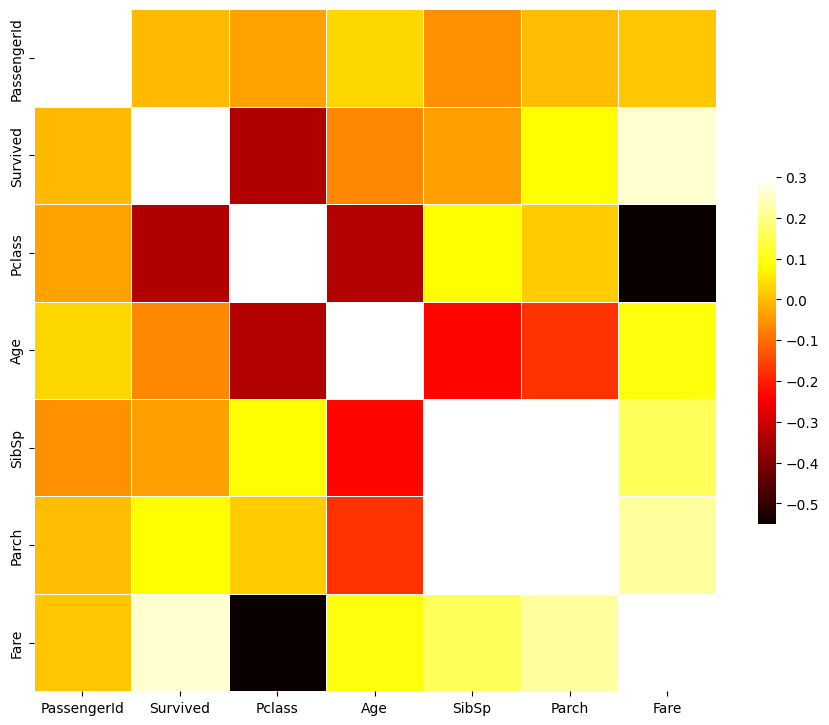

In [33]:
corr = df.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=None, cmap='hot', vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

There are no surprising strong correlations between the numerical features. There is strong negative correlation between Pclass and Survived,Pclass and Fare and positive correlation between Fare and Survived.

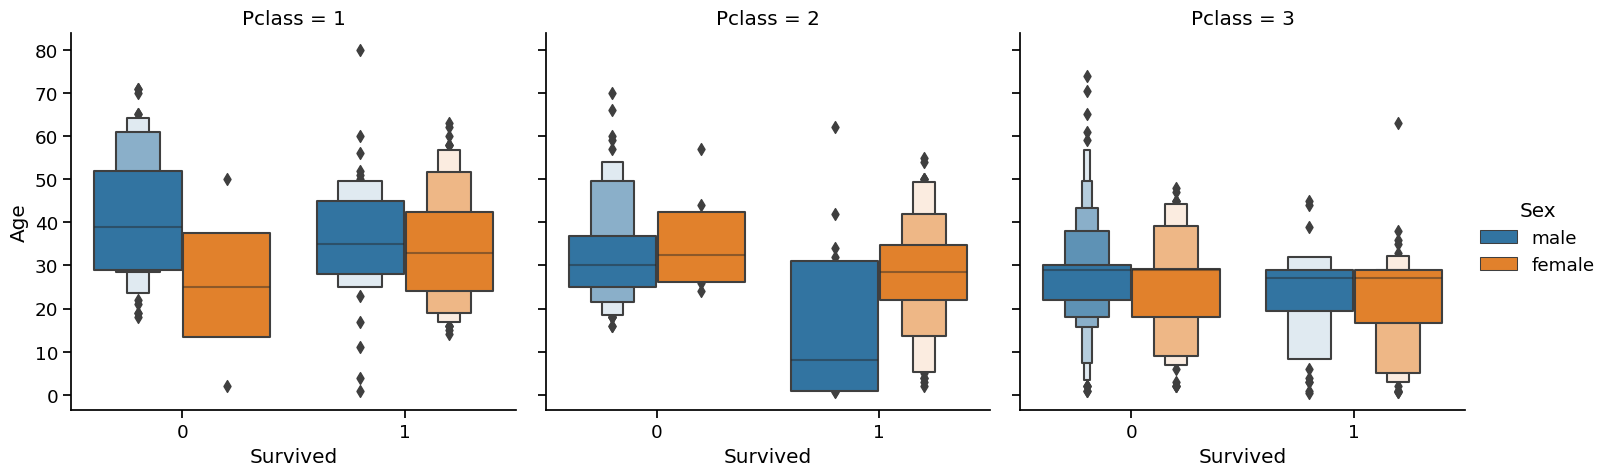

In [34]:
with sns.plotting_context('notebook',font_scale=1.2):
    ax = sns.catplot(
        x='Survived',
        y='Age',
        hue='Sex',
        col='Pclass',
        data=df,
        orient='v',
        kind='boxen',
    )

From this box plot we can see that in general, within stratifications for class and gender, the perished tended to be slightly older than the survivors, with the effect more pronounced among men.
Also we can see that Class 2 male survivors are comprised largely by children. We can see that the children male and female were saved entirely in Class 2, with no young among the perished (min age of perished ~ 17). This is in sharp contrast to Class 3, where the fate of children was more indiscriminate.

Text(0.5, 1.0, "Alone & Not Alone Passenger's Ages")

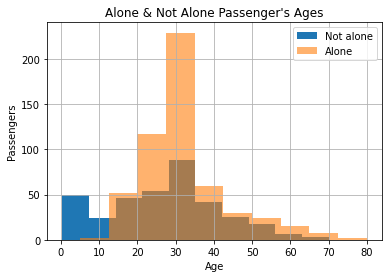

In [ ]:
is_not_alone = (df.SibSp + df.Parch) >= 1
passengers_not_alone = df[is_not_alone]

is_alone = (df.SibSp + df.Parch) == 0
passengers_alone = df[is_alone]

passengers_not_alone.Age.hist(label='Not alone')
passengers_alone.Age.hist(label='Alone', alpha=0.6)

plt.xlabel('Age')
plt.ylabel('Passengers')
plt.legend(loc='upper right')
plt.title('Alone & Not Alone Passenger\'s Ages')

From the above distribution we can see.  
Those in age range of 0-10, that is kids, were not alone.  
There however is one kid age 5 and a 80 year old person who where alone.  
Except for age group 0-10, for all other age groups, those travelling alone outnumbered those travelling not alone.


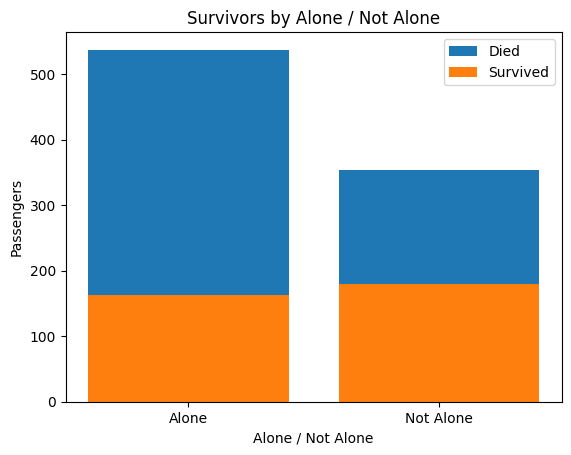

In [35]:
notalone = np.where((df.SibSp + df.Parch) >= 1, 'Not Alone', 'Alone')
loneliness_summary = df.groupby(notalone)['Survived'].agg([np.sum, np.size])
x = range(len(loneliness_summary.index.values))

y1 = loneliness_summary['size']
y2 = loneliness_summary['sum']

p1 = plt.bar(x, y1)
p2 = plt.bar(x, y2)

plt.xticks(x, loneliness_summary.index.values)
plt.xlabel('Alone / Not Alone')
plt.ylabel('Passengers')
plt.title('Survivors by Alone / Not Alone')
plt.legend([p1,p2],['Died', 'Survived'])

Percentage and visualizations above clearly indicate that people who where not alone had higher survival rate,while persentage of died and alone people is more than 50%.

In [36]:
# Drop columns that are not likely to contribute to survival prediction
df = df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

# Convert categorical variables to one-hot encoded columns
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)


We've removed columns that are unlikely to contribute significantly to survival prediction, such as 'PassengerId', 'Name', and 'Ticket'. Additionally, categorical variables like 'Sex' and 'Embarked' were transformed into a suitable format for modeling.

In [37]:
# Split the data into features and target
X = df.drop('Survived', axis=1)
y = df['Survived']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Data Split: The dataset has been divided into two parts: a training set and a testing set. This division helps us gauge how well the model performs on new, unseen data.

Feature Scaling: To ensure fair representation, we've standardized the features using the StandardScaler. This step prevents certain features from dominating the model's behavior.

We've constructed a simple neural network using the MLPClassifier from scikit-learn. The model consists of a single hidden layer with 64 units. The obtained accuracy of 81.01% provides insights into how well the model generalizes to new, unseen data.

# **Model Building and Evaluation**

In [48]:
# Create MLPClassifier
mlp_model = MLPClassifier()

# Hyperparameter Grid
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 64)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [200, 500]
}

# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(mlp_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get best hyperparameters and test accuracy
best_mlp_params = grid_search.best_params_
best_mlp_model = grid_search.best_estimator_
mlp_test_accuracy = best_mlp_model.score(X_test_scaled, y_test)

print("Best Hyperparameters for MLP:", best_mlp_params)
print("MLPClassifier Test Accuracy:", mlp_test_accuracy)


Best Hyperparameters for MLP: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (128,), 'max_iter': 200}
MLPClassifier Test Accuracy: 0.8212290502793296


Epoch 1/50
45/45 [==============================] - 1s 2ms/step - loss: 0.6340 - accuracy: 0.6531
Epoch 2/50
45/45 [==============================] - 0s 2ms/step - loss: 0.5318 - accuracy: 0.7851
Epoch 3/50
45/45 [==============================] - 0s 2ms/step - loss: 0.4802 - accuracy: 0.7935
Epoch 4/50
45/45 [==============================] - 0s 2ms/step - loss: 0.4536 - accuracy: 0.8160
Epoch 5/50
45/45 [==============================] - 0s 2ms/step - loss: 0.4381 - accuracy: 0.8104
Epoch 6/50
45/45 [==============================] - 0s 3ms/step - loss: 0.4285 - accuracy: 0.8090
Epoch 7/50
45/45 [==============================] - 0s 3ms/step - loss: 0.4228 - accuracy: 0.8118
Epoch 8/50
45/45 [==============================] - 0s 3ms/step - loss: 0.4177 - accuracy: 0.8202
Epoch 9/50
45/45 [==============================] - 0s 3ms/step - loss: 0.4137 - accuracy: 0.8258
Epoch 10/50
45/45 [==============================] - 0s 3ms/step - loss: 0.4101 - accuracy: 0.8301
Epoch 11/50
45/45 [

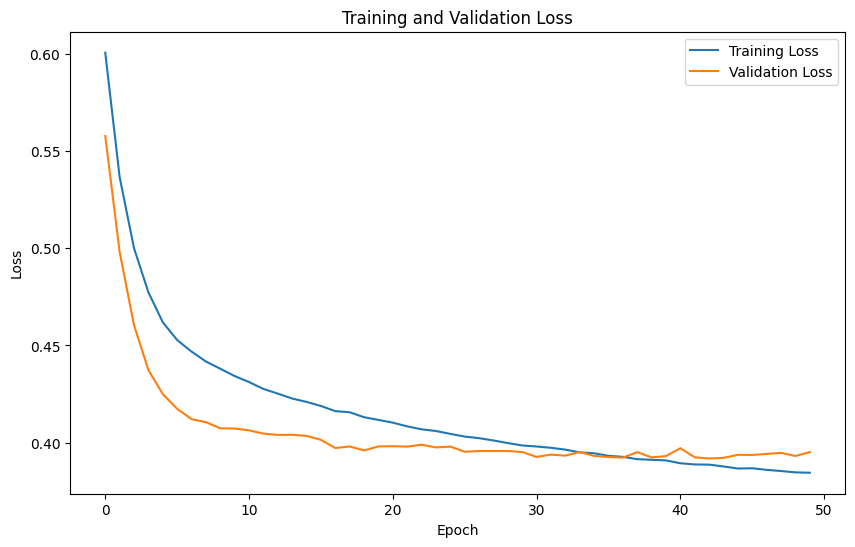

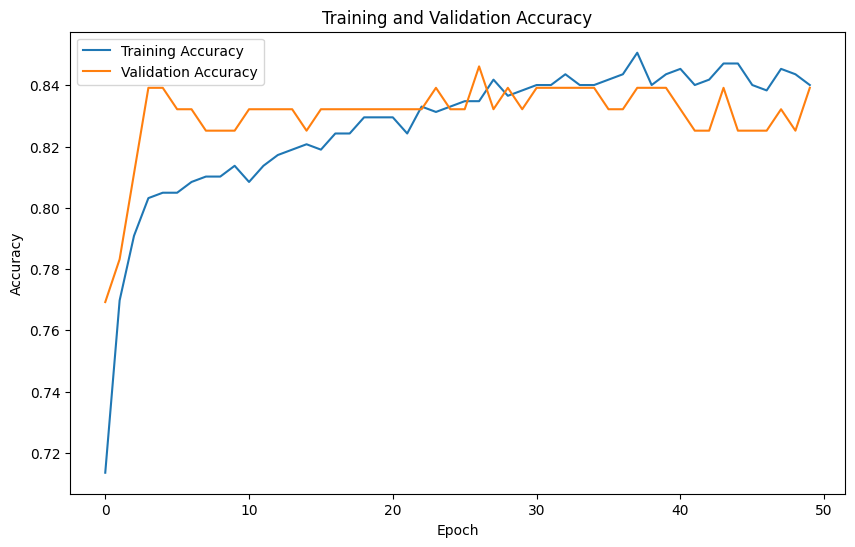

In [43]:
# Function to create Keras model
def create_sequential_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Create KerasClassifier
keras_model = KerasClassifier(build_fn=create_sequential_model)

# Hyperparameter Grid
param_grid = {
    'batch_size': [16, 32],
    'epochs': [50, 100],
    'optimizer': ['adam', 'rmsprop']
}

# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(keras_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get best hyperparameters and test accuracy
best_keras_params = grid_search.best_params_
best_keras_model = grid_search.best_estimator_
keras_test_accuracy = best_keras_model.score(X_test_scaled, y_test)

print("Best Hyperparameters for Keras:", best_keras_params)
print("Keras Test Accuracy:", keras_test_accuracy)

# Train the best model and collect history
best_model = create_sequential_model(optimizer=best_keras_params['optimizer'])
history = best_model.fit(X_train_scaled, y_train, epochs=best_keras_params['epochs'], batch_size=best_keras_params['batch_size'], validation_split=0.2, verbose=0)

# Plot training loss and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training accuracy and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


# **FInal report**

Keras Sequential Model achieved a test accuracy of 82.68% and
MLPClassifier Model achieved a test accuracy of 81.56%.
The results highlight the competitive performance of both models, showcasing their capability to generalize predictions to new, unseen data. While the Keras Sequential model exhibits a slightly higher accuracy, the difference between the two models is marginal.
Considering the test accuracy and the complexity of each model, I've opted to choose the Keras Sequential model as the optimal choice for this prediction task.